In [81]:
import torch
import albumentations as albu
from  torch.utils.data import random_split, DataLoader
from IPython.display import clear_output
from glob import glob
from torchvision import models
from tqdm.notebook import trange, tqdm
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import cv2 as cv

In [64]:
class Firestarter:
    """Fire naive cnn classification dataset."""

    def __init__(self, dir_pos:str, dir_neg:str, patt_pos:str='*', patt_neg:str='*', preproc=None, prep_before:bool=False, transform=None):
        """
        Args:
            dir_pos                       :   Path to the positive examples
            dir_neg                       :   Path to the negative examples
            patt_pos, patt_neg            :   Some bash syntax patterns of file names to load
            transform (callable, optional):   Optional transform to be applied on a sample.
            preproc   (callable, optional):   Optional preprocessing to be applied on a sample.
            prep_before                   :   if True preprocessing will be aplied while init and overwrite original images
        """
        dir_pos = dir_pos[:-1] if dir_pos[-1] == '/' else dir_pos
        dir_neg = dir_neg[:-1] if dir_neg[-1] == '/' else dir_neg
        #print(f'{dir_pos}/{patt_pos}')
        dir_pos, dir_neg = glob(f'{dir_pos}/{patt_pos}'), glob(f'{dir_neg}/{patt_neg}') 
        
        self.transform = transform
        self.preproc   = preproc
        self.ovrwrt    = prep_before
        self._len = len(dir_pos)+len(dir_neg)
        self.data = [(nam,0) for nam in dir_neg] +[(nam,1) for nam in dir_pos]
        
        
        if self.ovrwrt:
            for i in trange(self._len, desc='preprocessing images'):
                name,_ = data[i]
                img = cv.imread(name)
                img = self.preproc(img)
                cv.imwrite(name,img)
        
    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        img_name, otp = self.data[idx]
        #print(img_name,otp)
        img = cv.imread(img_name)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        img = hires_preproc(img)
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        if not self.ovrwrt and self.preproc:
            img = self.preproc(image=img)['image']

        return ( to_tensor(img),otp)

In [63]:
def hires_preproc(x):
        return cv.resize(x, (600,400), cv.INTER_AREA)


In [5]:
def get_augmentation():
    train_transform = [
        
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=(-20,20), shift_limit=0.1, p=1, border_mode=0),
        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(416, 544)
    ]
    return albu.Compose(test_transform)


def to_tensor(x):
    return x.transpose(2, 0, 1).astype('float32')


def get_preproc(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

In [6]:
DIR_POS = '../input/img-fire-pos/img/'
DIR_NEG ='../input/img-fire-neg/img_neg'

Just checking if everything is gonna crash

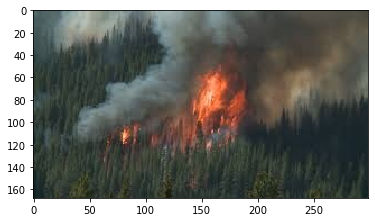

In [7]:
plt.imshow(Firestarter(DIR_POS,DIR_NEG)[190][0]);

from 

In [140]:
def train_model(model,dataloaders,dataset_sizes, device, criterion, optimizer, num_epochs=20, policy=True):
    if not os.path.isdir('./models'):
        os.mkdir('./models')
    #Being nice to not damage trained state
    optimizer.param_groups[0]['lr'] = 1e-4
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

            
    for epoch in trange(num_epochs, desc='EPOCH'):
        if device.type == 'cuda':
            print('MEM |', end='\t')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB', end='\t')
            print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB', end='\n')
        # Each epoch has a training and validation phase
        stats=dict()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            stats[f'{phase} acc'] = epoch_acc
            stats[f'{phase} loss'] = epoch_loss
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, './models/naive_resnet.pth')
                print('Model saved!')
            if policy and epoch == 5:
                optimizer.param_groups[0]['lr'] = 1e-3
            if policy and epoch == 15:
                optimizer.param_groups[0]['lr'] = 1e-4
        
        if epoch==0:
            fig = go.Figure()
            fig.update_xaxes(range=[0, num_epochs-1])
            for s in stats:
                fig.add_trace(go.Scatter(x=list(), y=list(),
                                mode='lines+markers',name=s))
        
        clear_output(wait=True)
        
        
        for j,s in enumerate(stats):
#             print(stats[s])
#             print(type(stats[s]))
            
            fig['data'][j]['x']+=(epoch,)
            fig['data'][j]['y']+=(float(stats[s]) ,)

        
        fig.show()
        
        
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [79]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

main_dataset = Firestarter(DIR_POS,DIR_NEG,transform =get_augmentation() )

tr_len = int(0.8*len(main_dataset))
val_len = int(0.15*len(main_dataset))
test_len = len(main_dataset) - tr_len - val_len
train_dataset, val_dataset, test_dataset = random_split(main_dataset,(tr_len,val_len,test_len ) )

image_datasets= {
                    'train': train_dataset,
                    'test': test_dataset,
                    'val':  val_dataset
                }


dataloaders = {x: DataLoader(image_datasets[x], batch_size=10,shuffle=True, num_workers=10) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [135]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(DEVICE)

#It isn't greate to double our parameters in the last layer, but it's quite tiny, so just leave what is working, BCELoss is similar except \
#mentioned duplicating
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())



In [94]:
torch.Tensor.cpu

<method 'cpu' of 'torch._C._TensorBase' objects>

Adam -- Adam-ом, но lr будем вначале и вконце брать маленьким. Видно, как сильно меняется на 5-15 эпохах при большом `lr`

In [139]:
model_ft = train_model(model_ft, dataloaders,dataset_sizes, DEVICE, criterion, optimizer_ft,20)


Training complete in 5m 31s
Best val Acc: 0.977778


Похоже `lr` был слишком большой. Не будем его менять на средних эпохах и уменьшим количество эпох

In [142]:
model_ft = train_model(model_ft, dataloaders,dataset_sizes, DEVICE, criterion, optimizer_ft,policy=False,num_epochs=15)


Training complete in 4m 10s
Best val Acc: 1.000000


Пока я ушел пить чай, эта негодница похоже переобучилась и пришлось делать преждевременную остановку, провалидируемся на тестовой выборке

In [143]:
best_model = torch.load('./models/naive_resnet.pth')

In [144]:
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [158]:
len(image_datasets['test'])

15


Acc: 0.9333333333333333, mean cpu inference time: 0.30114957491556804


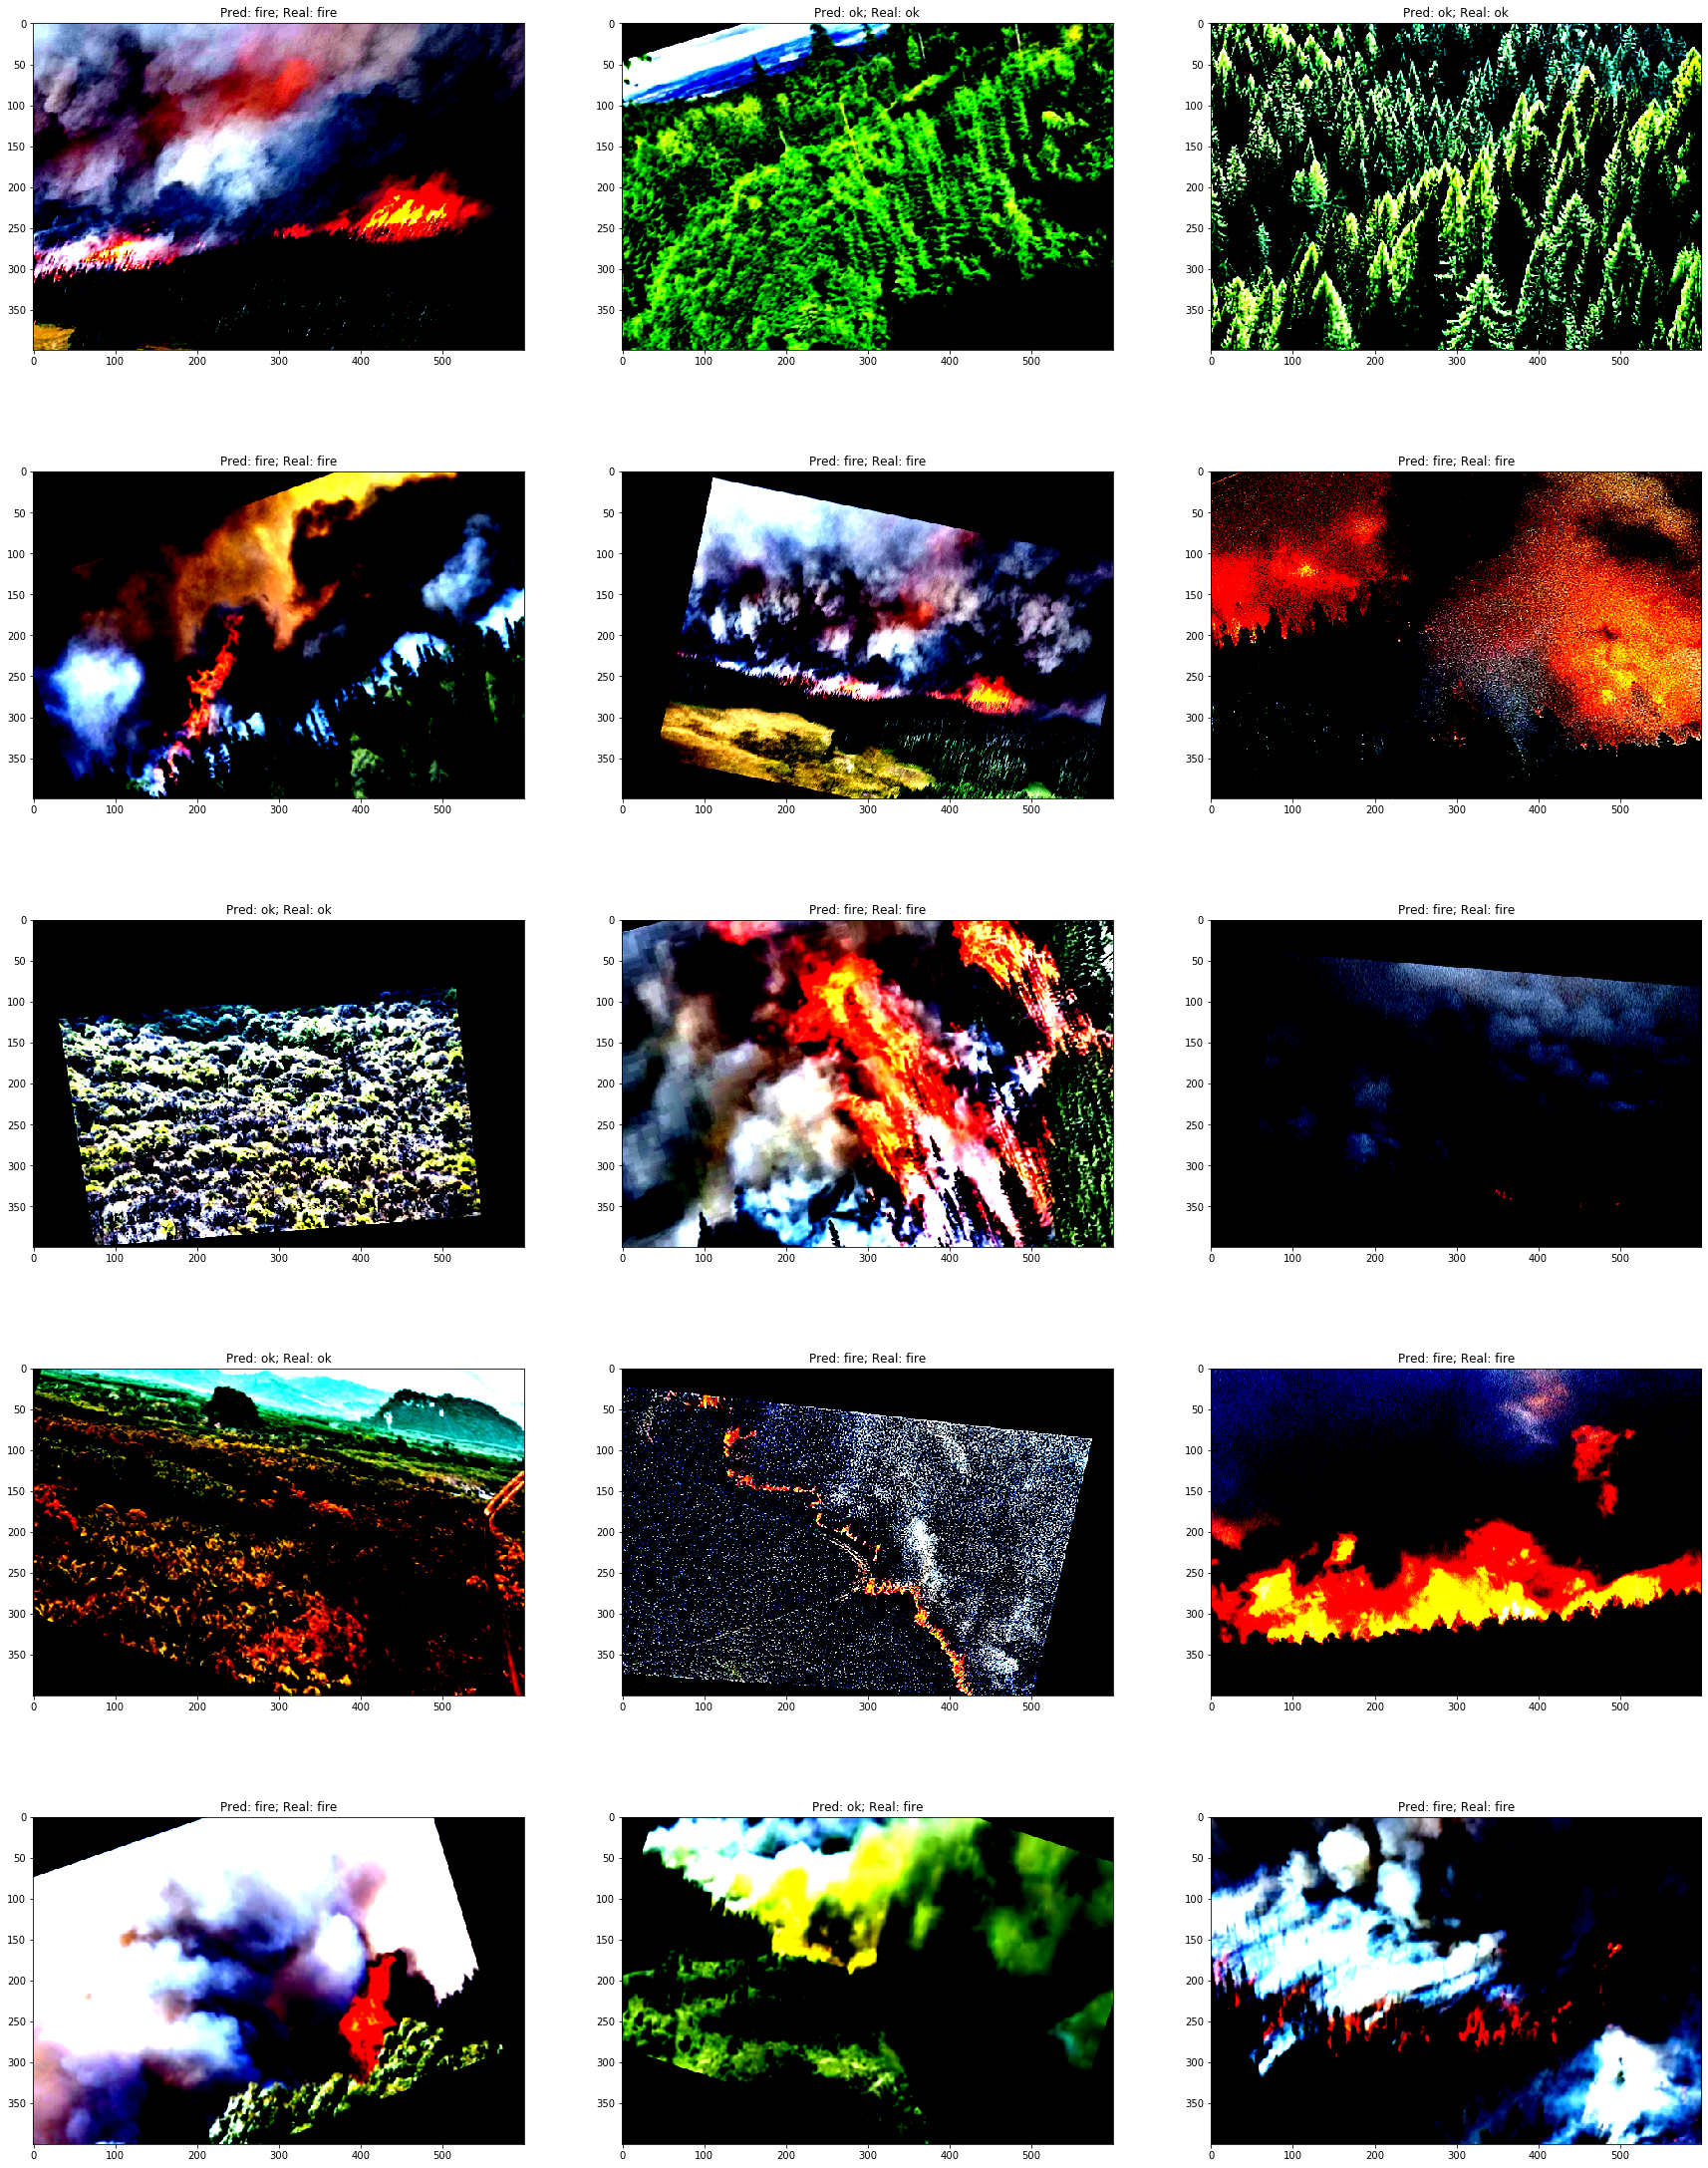

In [165]:
fig, axs = plt.subplots(5,3,figsize=(30,40))
running_corrects=0
inference_time=0

for i,(inputs, labels) in enumerate(tqdm(DataLoader(image_datasets['test'], batch_size=1,shuffle=True, num_workers=1))):
                inputs = inputs.to('cpu')
                labels = labels.to('cpu')
                axs[i//3][i%3].imshow(inputs.squeeze(0).permute(1,2,0).to('cpu'))
                
                since = time.time()
                outputs = best_model.to('cpu')(inputs)
                _, preds = torch.max(outputs, 1)
                end = time.time()
                inference_time+=end-since
                running_corrects += torch.sum(preds == labels.data)
                axs[i//3][i%3].set_title(f'Pred: {["ok", "fire"][preds[0]]}; Real: {["ok", "fire"][labels[0]]}')
            
epoch_loss = running_loss / len(image_datasets['test'])
epoch_acc = running_corrects.double() / len(image_datasets['test'])
print(f'Acc: {epoch_acc}, mean cpu inference time: {inference_time/len(image_datasets["test"])}')


Acc: 1.0, mean cpu inference time: 0.012079604466756185


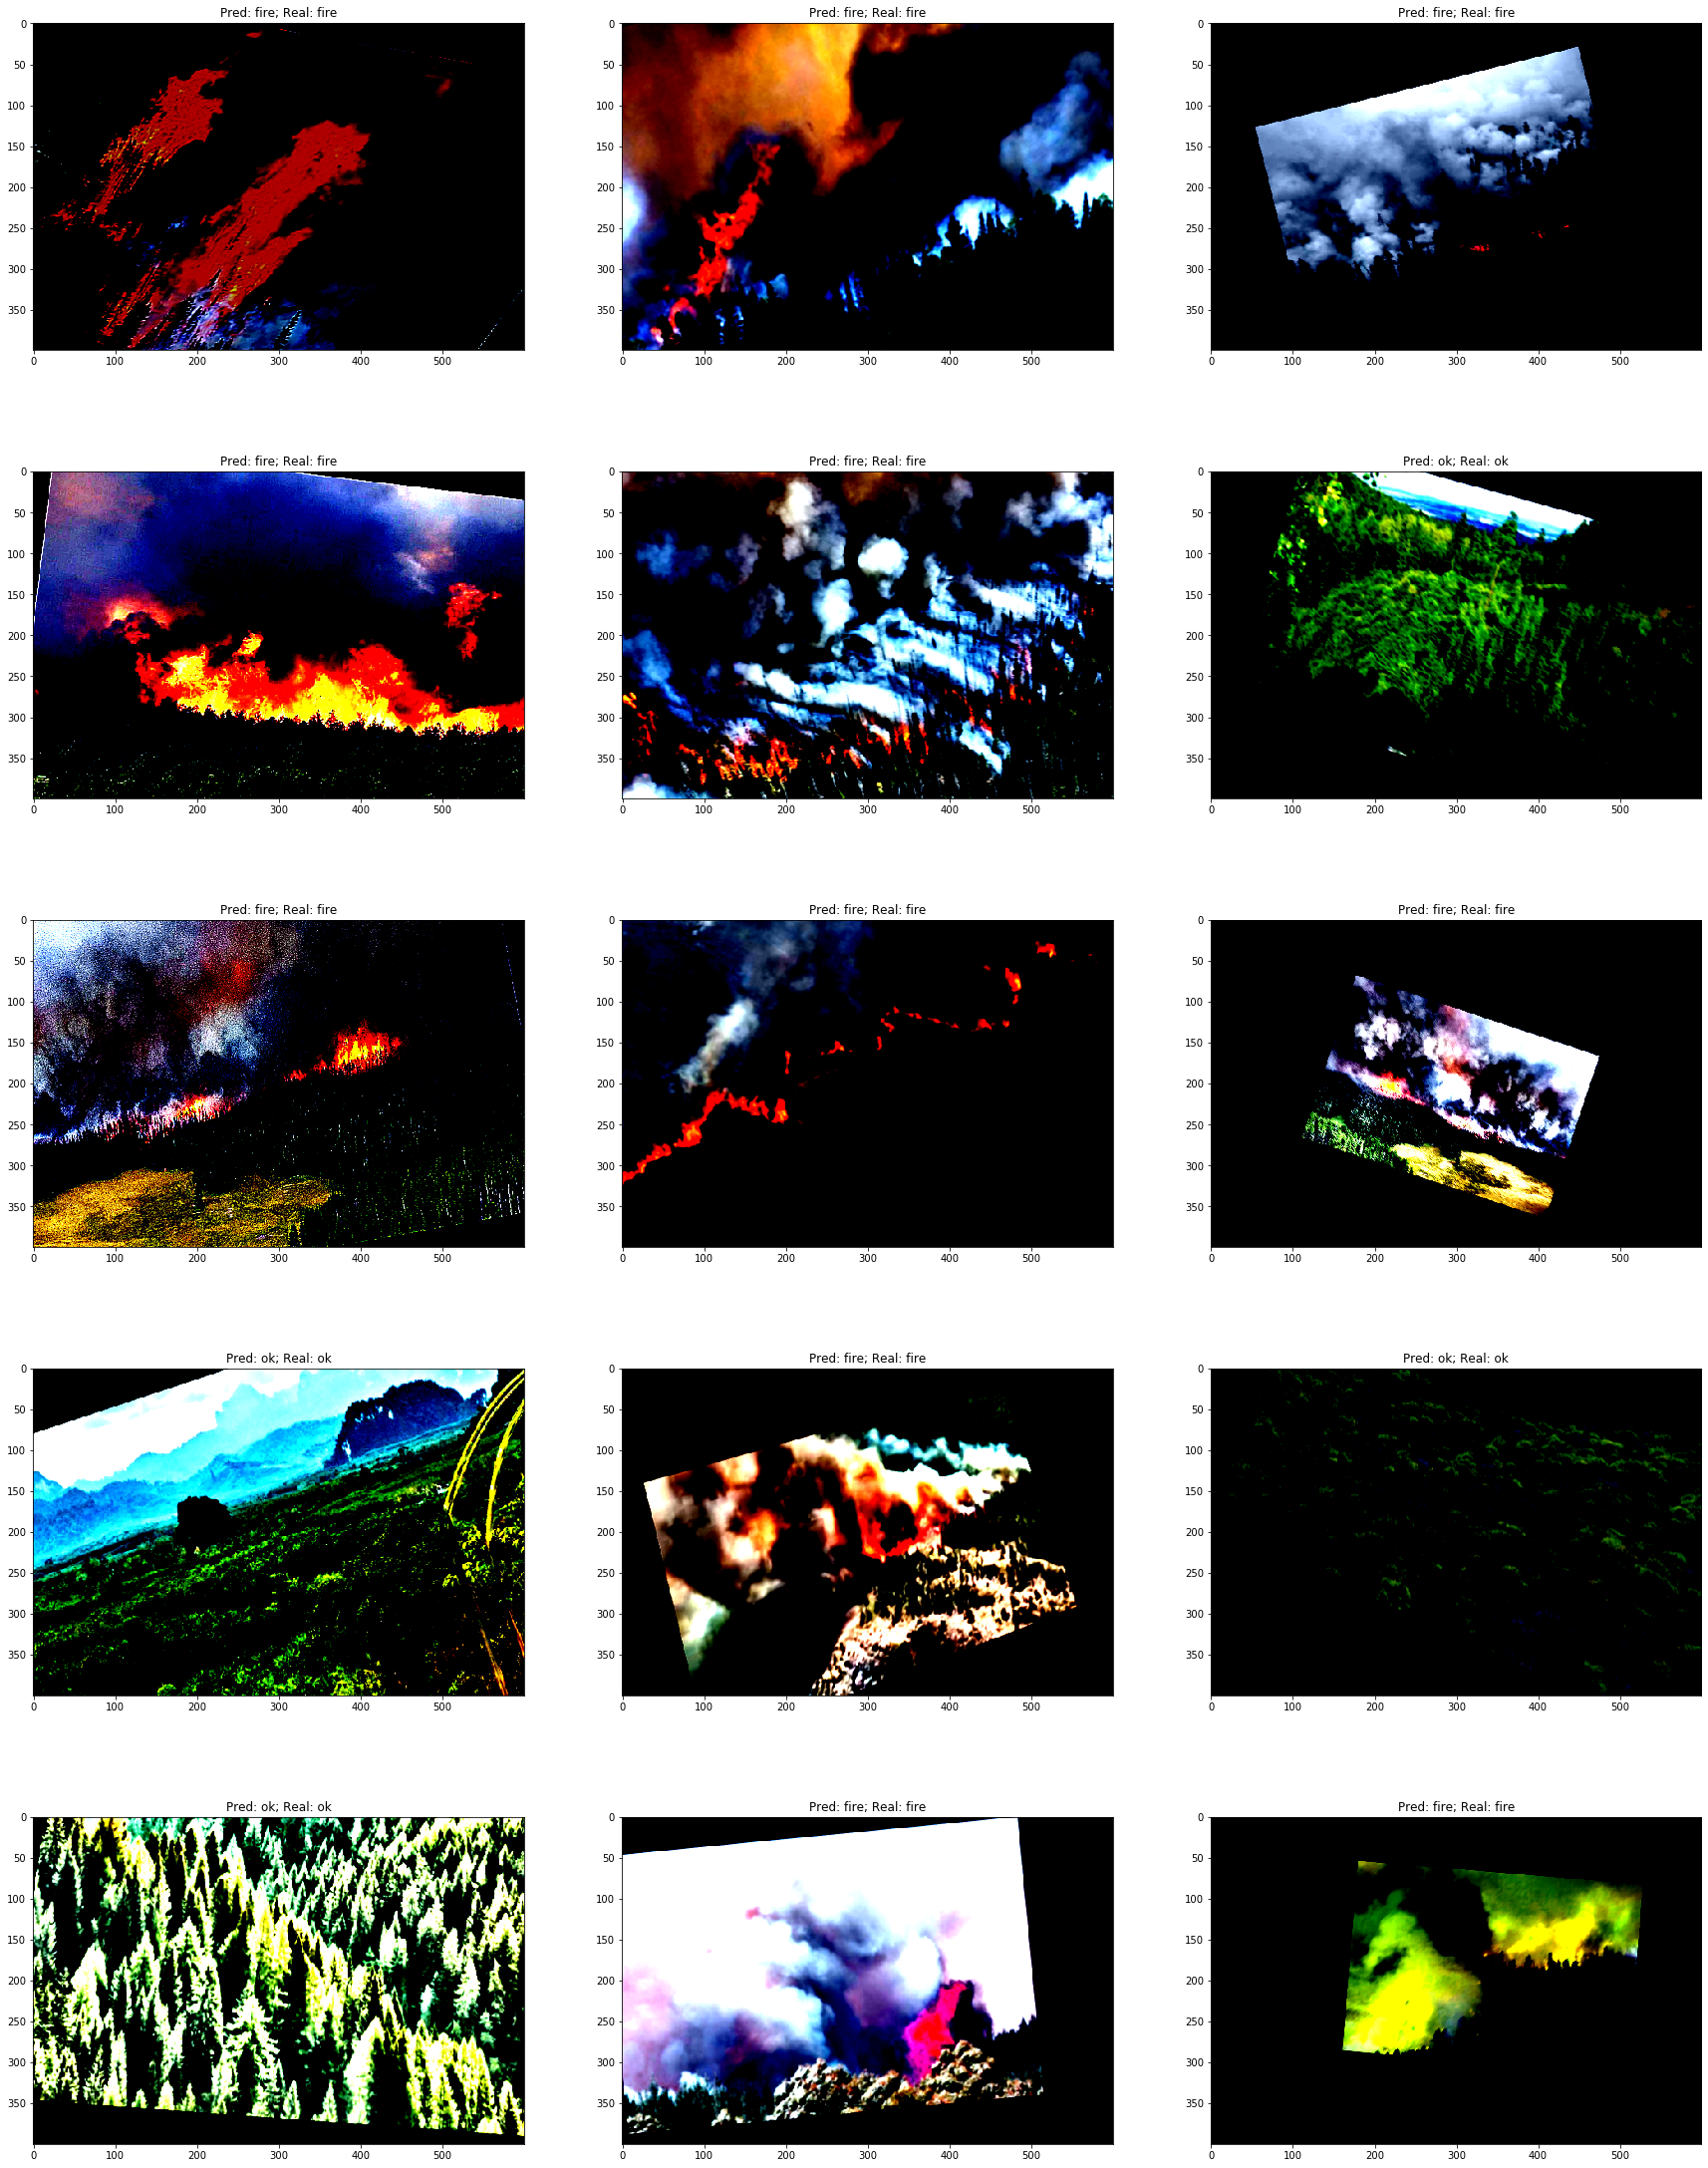

In [168]:
fig, axs = plt.subplots(5,3,figsize=(30,40))
running_corrects=0
inference_time=0

for i,(inputs, labels) in enumerate(tqdm(DataLoader(image_datasets['test'], batch_size=1,shuffle=True, num_workers=1))):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                axs[i//3][i%3].imshow(inputs.squeeze(0).permute(1,2,0).to('cpu'))
                
                since = time.time()
                outputs = best_model.to(DEVICE)(inputs)
                _, preds = torch.max(outputs, 1)
                end = time.time()
                inference_time+=end-since
                running_corrects += torch.sum(preds == labels.data)
                axs[i//3][i%3].set_title(f'Pred: {["ok", "fire"][preds[0]]}; Real: {["ok", "fire"][labels[0]]}')
            
epoch_loss = running_loss / len(image_datasets['test'])
epoch_acc = running_corrects.double() / len(image_datasets['test'])
print(f'Acc: {epoch_acc}, mean cpu inference time: {inference_time/len(image_datasets["test"])}')

Видно,что для gpu время для потоковой обработки приемлимое, для сpu -- нет

In [171]:
! less /proc/cpuinfo

{'python_version': '3.7.6.final.0 (64 bit)',
 'cpuinfo_version': [5, 0, 0],
 'arch': 'X86_64',
 'bits': 64,
 'count': 2,
 'raw_arch_string': 'x86_64',
 'vendor_id': 'GenuineIntel',
 'brand': 'Intel(R) Xeon(R) CPU @ 2.00GHz',
 'hz_advertised': '2.0000 GHz',
 'hz_actual': '2.0002 GHz',
 'hz_advertised_raw': [2000000000, 0],
 'hz_actual_raw': [2000176000, 0],
 'stepping': 3,
 'model': 85,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'adx',
  'aes',
  'apic',
  'arat',
  'arch_capabilities',
  'avx',
  'avx2',
  'avx512bw',
  'avx512cd',
  'avx512dq',
  'avx512f',
  'avx512vl',
  'bmi1',
  'bmi2',
  'clflush',
  'clflushopt',
  'clwb',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cx16',
  'cx8',
  'de',
  'erms',
  'f16c',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hypervisor',
  'ibpb',
  'ibrs',
  'invpcid',
  'invpcid_single',
  'lahf_lm',
  'lm',
  'mca',
  'mce',
  'md_clear',
  'mmx',
  'movbe',
  'mpx',
  'msr',
  'mtrr',
  'nonstop_tsc',
  'nopl',
  'nx',
  